In [3]:
import torch 
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
from torch.autograd import Variable
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from skimage.transform import resize
%matplotlib inline

In [5]:
num_epochs = 30
hidden_sizes = [512]
input_channels = 3
num_classes = 10
batch_size = 100
learning_rate = 0.001
lr_decay_epoch = 150

In [6]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda', index=0)

## Аугментация

In [7]:
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

train_dataset = torchvision.datasets.CIFAR10(root='dataset/',
                                           train=True, 
                                           transform=transform,
                                           download=True)

test_dataset = torchvision.datasets.CIFAR10(root='dataset/',
                                          train=False, 
                                          transform=transform,
                                          download=True)

Files already downloaded and verified
Files already downloaded and verified


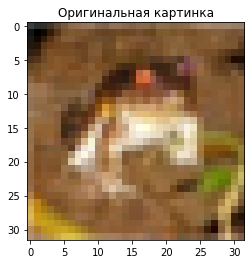

In [8]:
sample_image = train_dataset.data[0]
sample_to_pil = transforms.ToPILImage()(sample_image)
plt.imshow(sample_to_pil)
plt.title('Оригинальная картинка')
plt.show()

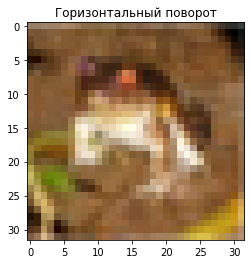

In [9]:
sample_flipped = transforms.RandomHorizontalFlip(1)(sample_to_pil)
plt.imshow(sample_flipped)
plt.title('Горизонтальный поворот')
plt.show()

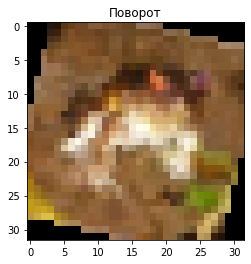

In [10]:
sample_rotated = transforms.RandomRotation(degrees=15)(sample_to_pil)
plt.imshow(sample_rotated)
plt.title('Поворот')
plt.show()

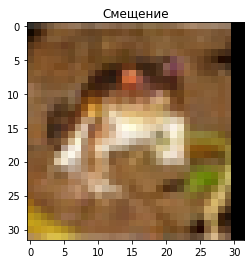

In [11]:
sample_translated_hori = transforms.RandomAffine(degrees=0, translate=(0.2,0))(sample_to_pil)
plt.imshow(sample_translated_hori)
plt.title('Смещение')
plt.show()

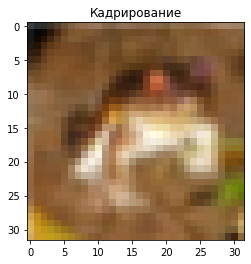

In [12]:
sample_resized_crop = torchvision.transforms.RandomResizedCrop(size=32, scale=(0.8, 1.0))(sample_to_pil)
plt.imshow(sample_resized_crop)
plt.title('Кадрирование')
plt.show()

## Загрузка датасета

In [13]:
transform = transforms.Compose(
    [transforms.RandomHorizontalFlip(0.5),
     transforms.RandomAffine(degrees=15, translate=(0.1,0.1)),
     transforms.RandomResizedCrop(size=32, scale=(0.8, 1.0)),
     transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

train_dataset = torchvision.datasets.CIFAR10(root='dataset/',
                                           train=True, 
                                           transform=transform,
                                           download=True)

test_dataset = torchvision.datasets.CIFAR10(root='dataset/',
                                          train=False, 
                                          transform=transform,
                                          download=True)

Files already downloaded and verified
Files already downloaded and verified


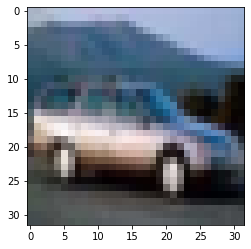

In [14]:
plt.imshow(train_dataset.data[4])
plt.show()

In [15]:
print('Original train size:', train_dataset.data.shape)
print(len(train_dataset.targets))
print('Original test size:', test_dataset.data.shape)
print(len(test_dataset.targets))

Original train size: (50000, 32, 32, 3)
50000
Original test size: (10000, 32, 32, 3)
10000


In [16]:
train_loader = torch.utils.data.DataLoader(dataset=train_dataset,
                                           batch_size=batch_size, 
                                           shuffle=True)

test_loader = torch.utils.data.DataLoader(dataset=test_dataset,
                                          batch_size=batch_size, 
                                          shuffle=False)

In [17]:
classes = train_dataset.classes
classes

['airplane',
 'automobile',
 'bird',
 'cat',
 'deer',
 'dog',
 'frog',
 'horse',
 'ship',
 'truck']

In [18]:
sample_train_data = iter(train_loader)
images, labels = sample_train_data.next()

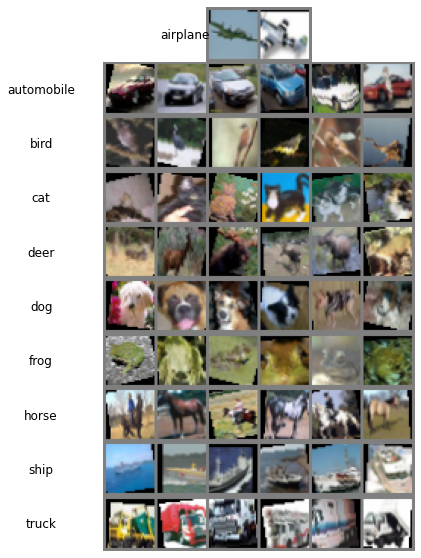

In [19]:
sample_train_data = iter(train_loader)
images, labels = sample_train_data.next()

fig = plt.figure(figsize = (10, 10))
fig.subplots_adjust(hspace=0, wspace=0)
def show_photo(img, i, lname):
    img = img / 2 + 0.5
    npimg = img.detach().cpu().numpy()
    ax = fig.add_subplot(10, 1, i, xticks=[], yticks=[])
    ax.imshow(np.transpose(npimg, (1, 2, 0)))
    ax.axis('off')
    ax.set_title(label=lname, x=-0.2, y=0.3)

for label, lname in enumerate(classes):
    target_label = (labels == label)
    imgs = images[target_label][:6]
    show_photo(torchvision.utils.make_grid(imgs), label + 1, lname)

In [20]:
class MyCNNModel(nn.Module):
    def __init__(self, input_channels, num_classes=10):
        super(MyCNNModel, self).__init__()

        self.layer1 = nn.Sequential(
            nn.Conv2d(in_channels=input_channels, out_channels=64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2))        
        
        self.layer2 = nn.Sequential(
            nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.Dropout(0.4),
            nn.Conv2d(in_channels=128, out_channels=128, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2))

        self.layer3 = nn.Sequential(
            nn.Conv2d(in_channels=128, out_channels=256, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.Dropout(0.4),
            nn.Conv2d(in_channels=256, out_channels=256, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.Dropout(0.4),
            nn.Conv2d(in_channels=256, out_channels=256, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2))

        self.layer4 = nn.Sequential(
            nn.Conv2d(in_channels=256, out_channels=512, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(),
            nn.Dropout(0.4),
            nn.Conv2d(in_channels=512, out_channels=512, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(),
            nn.Dropout(0.4),
            nn.Conv2d(in_channels=512, out_channels=512, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2))

        self.layer5 = nn.Sequential(
            nn.Conv2d(in_channels=512, out_channels=512, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(),
            nn.Dropout(0.4),
            nn.Conv2d(in_channels=512, out_channels=512, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(),
            nn.Dropout(0.4),
            nn.Conv2d(in_channels=512, out_channels=512, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Dropout(0.5))

        self.layer6 = nn.Sequential(
            nn.Linear(512 * 1 * 1, hidden_sizes[0]),
            nn.BatchNorm1d(512),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(hidden_sizes[0], num_classes))

    def forward(self, x):
        out = self.layer1(x)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.layer4(out)
        out = self.layer5(out)
        out = out.view(out.size(0), -1)
        out = self.layer6(out)
        
        return out

In [21]:
model = MyCNNModel(input_channels, num_classes).to(device)

In [22]:
criterion = nn.CrossEntropyLoss()

In [23]:
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

In [24]:
exp_lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=lr_decay_epoch, gamma=0.1)

In [25]:
iter = 0
accuracies = []
losses = []
for epoch in range(num_epochs):
    exp_lr_scheduler.step()
    print('Epoch - ', epoch)
    for i, (images, labels) in enumerate(train_loader):
        images = Variable(images).to(device)
        labels = Variable(labels).to(device)
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        iter += 1 

    correct = 0
    total = 0
    model.eval()
    with torch.no_grad():            
        for images, labels in test_loader:
            images = Variable(images).to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted.to(device) == labels.to(device)).sum()
        accuracy = 100 * correct / total
        accuracies.append(accuracy.detach().cpu().numpy())
        losses.append(loss.data.item())

    print('Iteration: {}. Loss: {}. Accuracy: {}'.format(iter, loss.data.item(), accuracy))

C:\ProgramData\Anaconda3\lib\site-packages\torch\optim\lr_scheduler.py:131: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  warnings.warn("Detected call of `lr_scheduler.step()` before `optimizer.step()`. "


Epoch -  0
Iteration: 500. Loss: 1.8608887195587158. Accuracy: 30.119998931884766
Epoch -  1
Iteration: 1000. Loss: 1.502709984779358. Accuracy: 39.34000015258789
Epoch -  2
Iteration: 1500. Loss: 1.4647578001022339. Accuracy: 46.43000030517578
Epoch -  3
Iteration: 2000. Loss: 1.3767445087432861. Accuracy: 54.13999938964844
Epoch -  4
Iteration: 2500. Loss: 1.0451171398162842. Accuracy: 59.619998931884766
Epoch -  5
Iteration: 3000. Loss: 1.0433976650238037. Accuracy: 64.68999481201172
Epoch -  6
Iteration: 3500. Loss: 1.0876777172088623. Accuracy: 66.4000015258789
Epoch -  7
Iteration: 4000. Loss: 1.0478812456130981. Accuracy: 68.38999938964844
Epoch -  8
Iteration: 4500. Loss: 0.693817138671875. Accuracy: 72.55999755859375
Epoch -  9
Iteration: 5000. Loss: 0.7279361486434937. Accuracy: 72.81999969482422
Epoch -  10
Iteration: 5500. Loss: 0.5107296109199524. Accuracy: 75.68999481201172
Epoch -  11
Iteration: 6000. Loss: 0.5802173018455505. Accuracy: 76.04000091552734
Epoch -  12
Iter

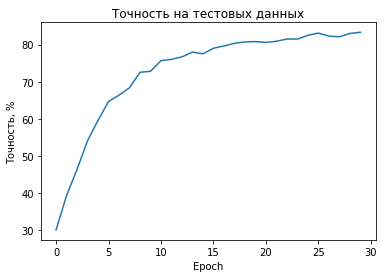

In [26]:
plt.plot(accuracies)
plt.title('Точность на тестовых данных')
plt.xlabel('Epoch')
plt.ylabel('Точность, %')
plt.show()

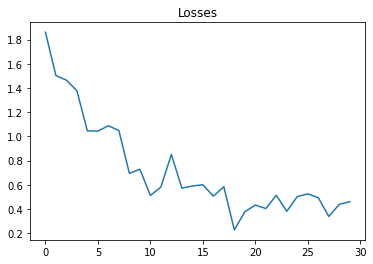

In [27]:
plt.plot(losses)
plt.title('Losses')
plt.show()

In [48]:
torch.save(model, 'model.pth')

In [50]:
incorrect_predictions = []

model.eval()
heat_map_matrix = np.zeros((10, 10))
with torch.no_grad():
    correct = 0
    total = 0
    for images, labels in test_loader:
        images = Variable(images).to(device)
        labels = Variable(labels)
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted.to(device) == labels.to(device)).sum().item()
        for i in range(len(labels)):
            heat_map_matrix[labels[i]][predicted[i]] += 1
     
    print('Test Accuracy of the model on the 10000 test images: {} %'.format(100 * correct / total))

Test Accuracy of the model on the 10000 test images: 83.9 %


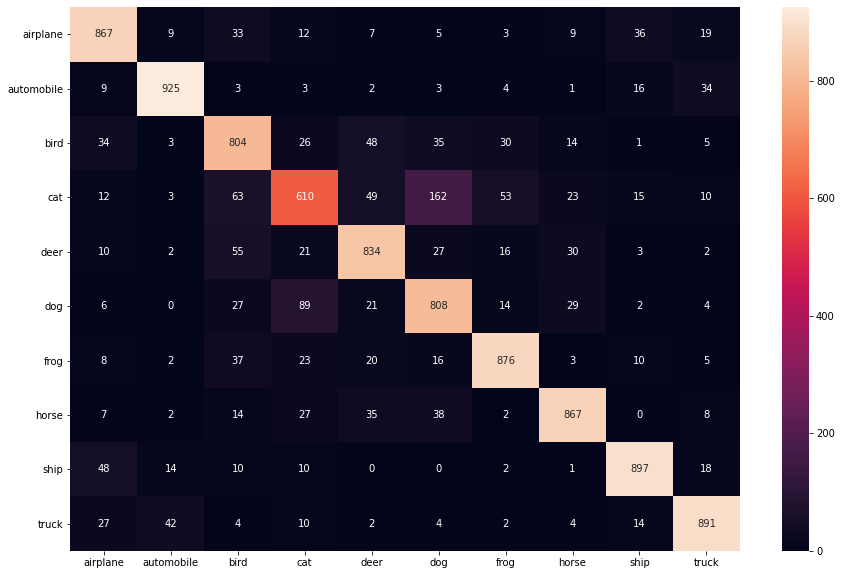

In [47]:
import seaborn as sns
import pandas as pd
heat_map_matrix = pd.DataFrame(heat_map_matrix, columns=classes)
heat_map_matrix.index = classes
plt.figure(1, (15, 10))
sns.heatmap(heat_map_matrix, annot=True, fmt='g')
plt.show()

In [21]:
def predict_class(img_name):
    num_px = 32
    classes = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
    model = torch.load('model.pth')
    device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
    
    image = np.array(plt.imread(img_name))
    my_image = resize(image,(num_px,num_px)).reshape(num_px, num_px, 3)
    my_image = my_image.transpose((2, 0, 1))
    my_image = np.expand_dims(my_image, axis=0).astype('f4')
    my_image = Variable(torch.from_numpy(my_image)).to(device)
    output = model(my_image).to(device)
    _, predicted = torch.max(output.data, 1)
    return classes[predicted.item()]

In [22]:
predict_class('img/plane.jpg')

'airplane'